In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Convertion rate challenge
### Cristian Garay

## Goal of the exercise

The goal of this exercise is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.

We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

The project is to:
- Predict conversion rate
- Come up with recommendations for the product team and the marketing team to improve conversion rate

## Data exploration

In [2]:
data_original = pd.read_csv('conversion_data.csv')
data_original.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


Columns:
- country : user country based on the IP address
- age : user age. Self-reported at sign-in step
- new_user : whether the user created the account during this session or had already an account and simply came back to the site
- source : marketing channel source
    - Ads: came to the site by clicking on an advertisement
    - Seo: came to the site by clicking on search results
    - Direct: came to the site by directly typing the URL on the browser
- total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. 

__The company goal is to increase conversion rate: # conversions / total sessions.__

Number of rows in the data set:

In [11]:
len(data_original)

316200

In [3]:
data_original.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


A couple of interesting things from the above description of our data:

- The age range for our users is 17 to 123. The max value of this range indicates that there may be some problems with the data recorded, although it is posible for a person of 123 years of age to be using the website, seems a bit strange.
- 75% of our data points correspond to people under the age of 36.
- 68% are new users.
- The mean number of pages visited in a session is 4.9.
- The mean convertion can be seen as the mean conversion rate of the data set, in this case 3%.

Let's explore the super high ages we found in the description of the data set.

In [12]:
data_original.sort_values(by='age', ascending=False).head(10)

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0
208969,US,72,1,Direct,4,0
301366,UK,70,0,Ads,5,0
114485,US,70,1,Ads,9,0
57122,UK,69,1,Direct,4,0
290142,US,69,1,Seo,6,0


Still feels a bit strange to have 2 users with ages 123 and 111. They both converted and have really high number of total pages visited. Since these are only 2 data points (of more than 360,000) if would remove them just to be safe.

In [18]:
data_cleaned = data_original[data_original['age'] < 100]
len(data_cleaned)

316198

Lets see if our data set has some missing values:

In [19]:
data_cleaned.isnull().values.any()

False

No missing values on our data set.

In [20]:
data_cleaned.groupby('converted').mean()

,age,new_user,total_pages_visited
converted,,,
0,30.703961,0.698382,4.550281
1,26.529025,0.298000,14.553932


Seems to be a clear relationship between total_pages visited and converted. Also the mayority of converted are old users. Either seems a good idea to make new users come back, or to find out why people don't convert on the first visit.

In [31]:
data_cleaned.groupby('source').mean()

,age,new_user,total_pages_visited,converted
source,,,,
Ads,30.533835,0.685708,4.899480,0.034472
Direct,30.567978,0.686854,4.816901,0.028169
Seo,30.590239,0.684686,4.883881,0.032888


There seems to be no much of a relationship for source and convertion rates.

In [32]:
data_cleaned.groupby('country').mean()

,age,new_user,total_pages_visited,converted
country,,,,
China,30.672972,0.698520,4.553523,0.001332
Germany,30.442895,0.677288,5.189966,0.062428
UK,30.449875,0.679849,5.082066,0.052612
US,30.566482,0.681985,4.930160,0.037801


Looking at country-based data, the Chinese convertion rate seems very low.

## Data visualization

In [23]:
%matplotlib inline

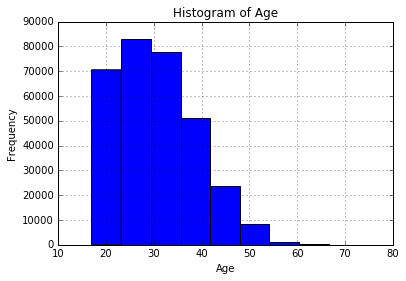

In [24]:
data_cleaned['age'].hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

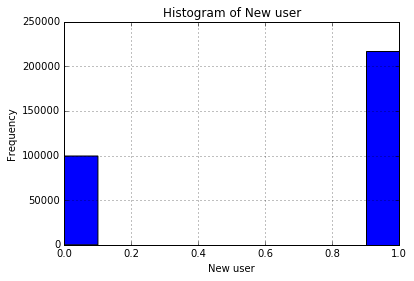

In [25]:
data_cleaned['new_user'].hist()
plt.title('Histogram of New user')
plt.xlabel('New user')
plt.ylabel('Frequency')

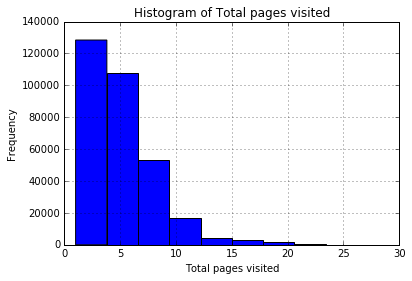

In [26]:
data_cleaned['total_pages_visited'].hist()
plt.title('Histogram of Total pages visited')
plt.xlabel('Total pages visited')
plt.ylabel('Frequency')

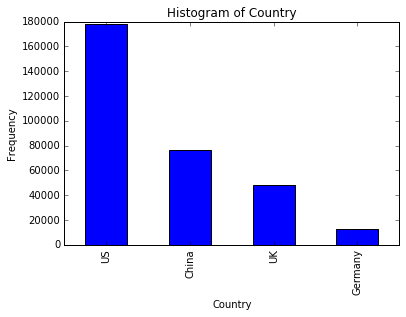

In [40]:
data_cleaned['country'].value_counts().plot(kind='bar')
plt.title('Histogram of Country')
plt.xlabel('Country')
plt.ylabel('Frequency')

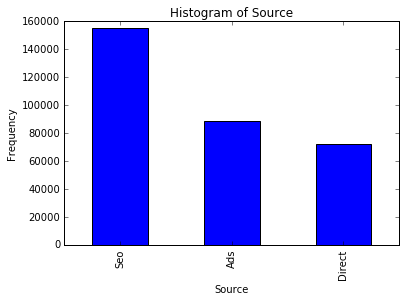

In [42]:
data_cleaned['source'].value_counts().plot(kind='bar')
plt.title('Histogram of Source')
plt.xlabel('Source')
plt.ylabel('Frequency')

## Data preparation

For logistic regrasion I'll create dummy variables for country and source.

In [43]:
dummy_country = pd.get_dummies(data_cleaned['country'], prefix='country')
dummy_country.head()

,country_China,country_Germany,country_UK,country_US
0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0


In [44]:
dummy_source = pd.get_dummies(data_cleaned['source'], prefix='source')
dummy_source.head()

,source_Ads,source_Direct,source_Seo
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [45]:
data_lr = data_cleaned[['age', 'new_user', 'total_pages_visited', 'converted']].join([dummy_country, dummy_source])
data_lr.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,23,1,5,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,28,1,4,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,39,1,5,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,30,1,6,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Logistic regression

In [51]:
#still don't get why I have to remove the first dummy value for each dummy variable (has to do with the intercept?)
feature_cols = ['age', 'new_user', 'total_pages_visited', 'country_Germany', 'country_UK', 'country_US', 'source_Direct', 'source_Seo']
X = data_lr[feature_cols]
y = data_lr['converted']

In [52]:
model = LogisticRegression()

In [61]:
model = model.fit(X, y)

In [60]:
dict(zip(X.columns, np.transpose(model.coef_)))

{'age': array([-0.07544001]),
 'country_Germany': array([ 3.53527077]),
 'country_UK': array([ 3.34178691]),
 'country_US': array([ 2.98227166]),
 'new_user': array([-1.73510705]),
 'source_Direct': array([-0.19067468]),
 'source_Seo': array([-0.03099016]),
 'total_pages_visited': array([ 0.75292384])}

In [50]:
model.intercept_

array([-4.84353668])